In [46]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier


In [2]:
df = pd.read_csv('Occupancy_Estimation.csv')
df.head(10)

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1
5,2017/12/22,10:52:14,25.00,24.81,24.56,25.44,121,34,54,40,0.13,0.06,0.06,0.07,390,0.165385,0,0,1
6,2017/12/22,10:52:45,25.00,24.75,24.56,25.44,120,34,54,40,1.39,0.32,0.43,0.06,390,0.076923,1,0,1
7,2017/12/22,10:53:15,25.00,24.81,24.56,25.44,121,34,54,41,0.09,0.06,0.09,0.05,390,-0.011538,0,0,1
8,2017/12/22,10:53:46,25.00,24.81,24.56,25.50,122,35,56,43,0.09,0.05,0.06,0.13,390,-0.100000,0,0,1
9,2017/12/22,10:54:17,25.00,24.81,24.56,25.50,101,34,57,43,3.84,0.64,0.48,0.39,390,-0.188462,1,1,1


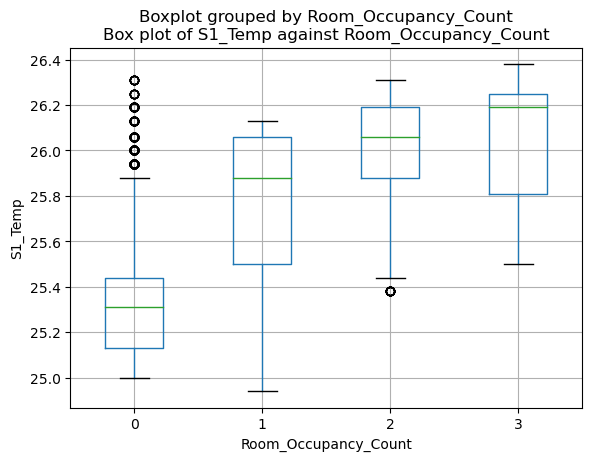

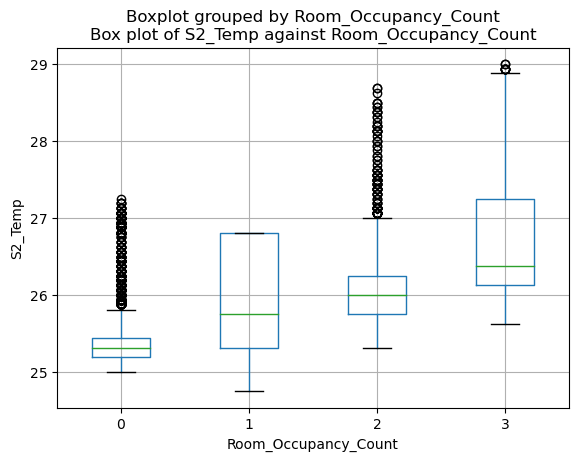

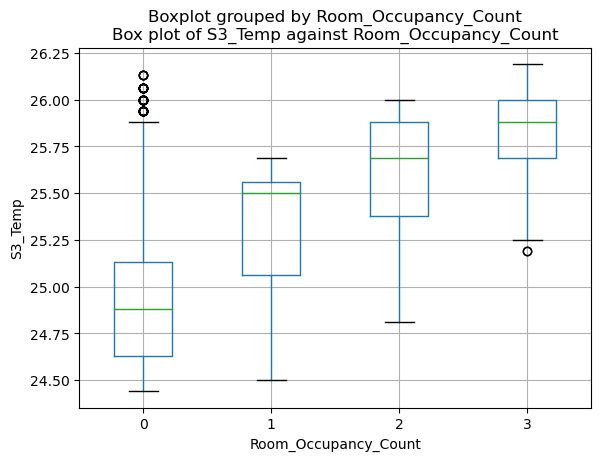

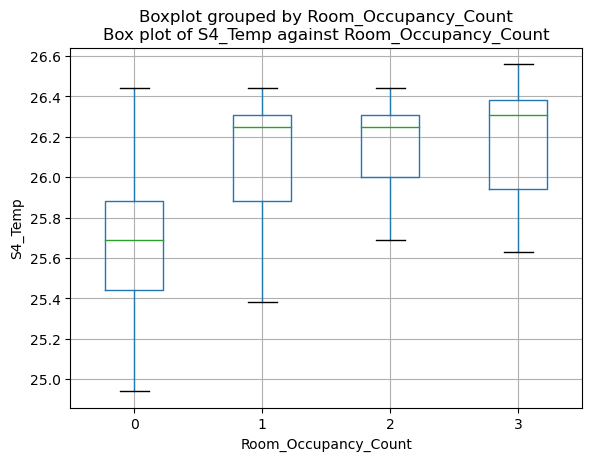

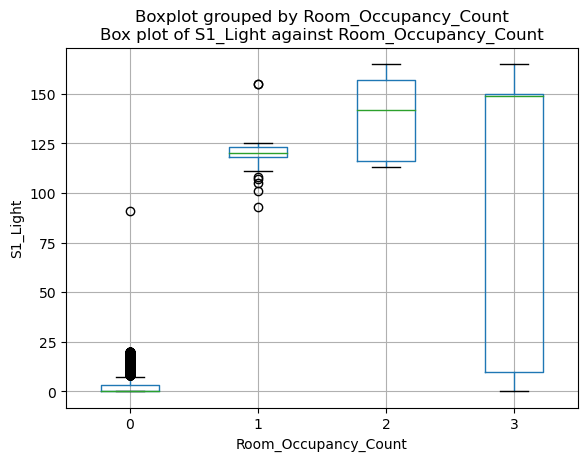

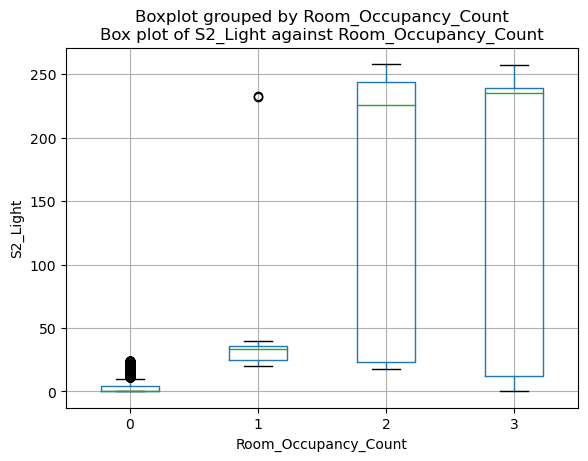

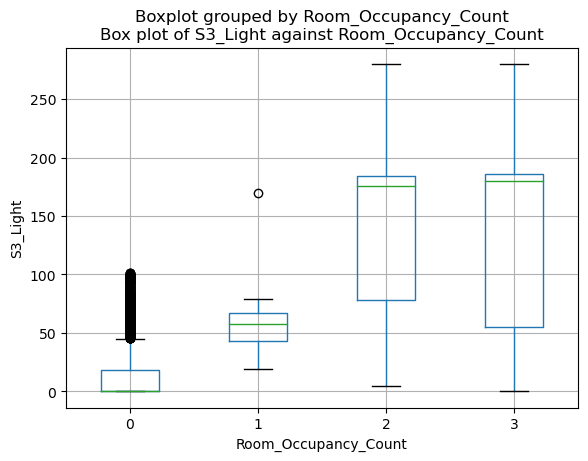

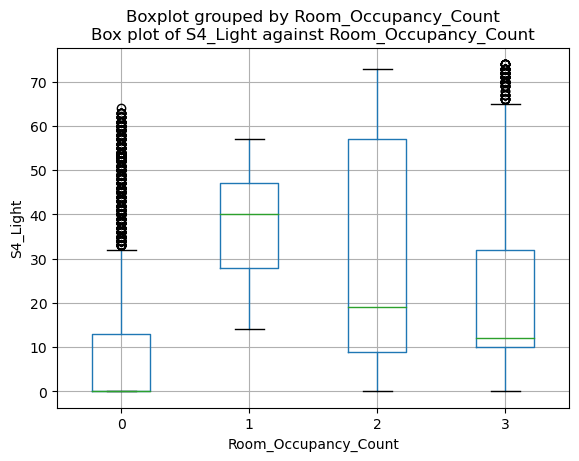

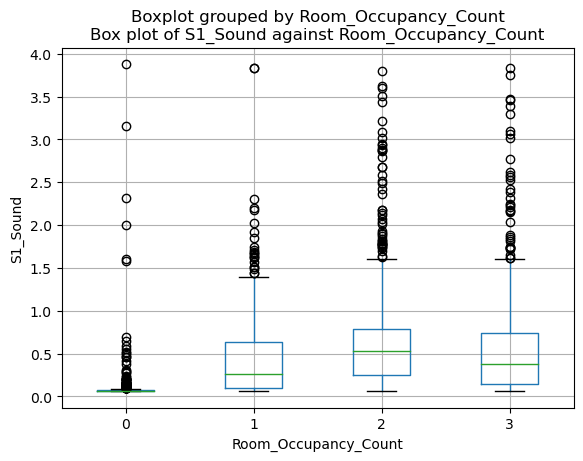

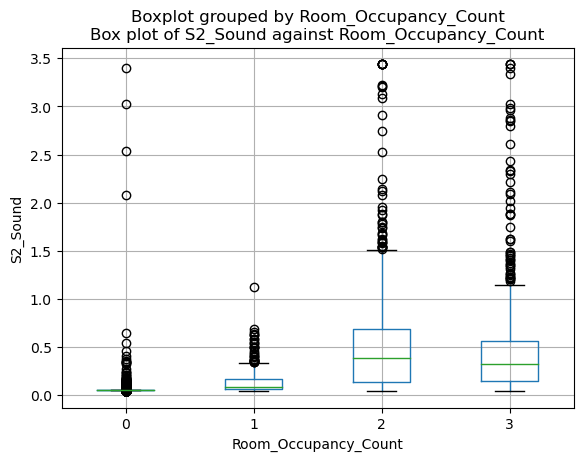

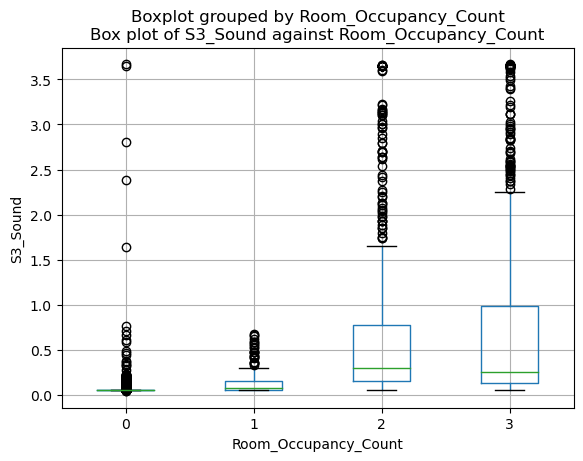

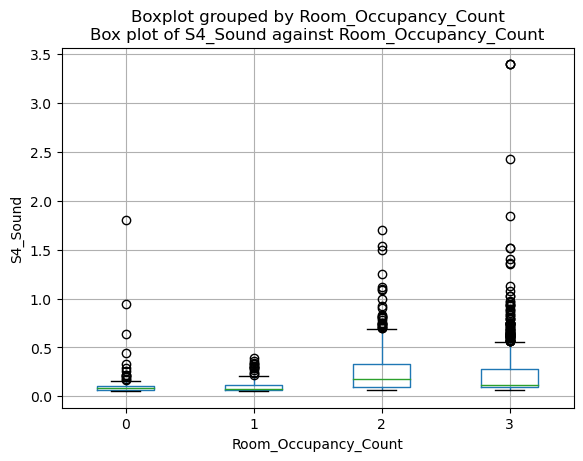

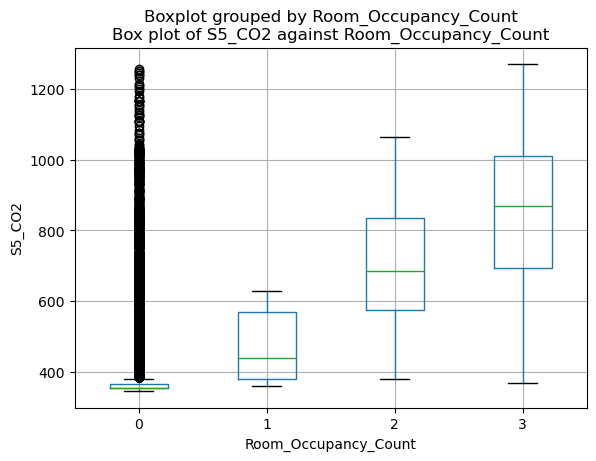

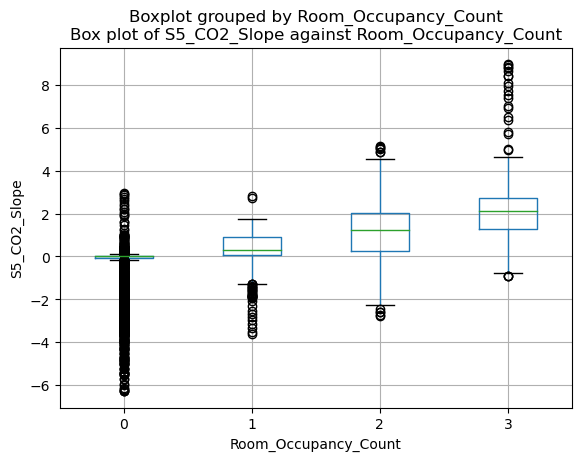

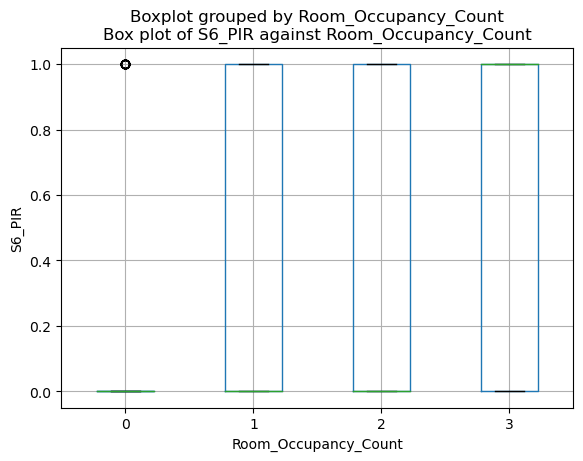

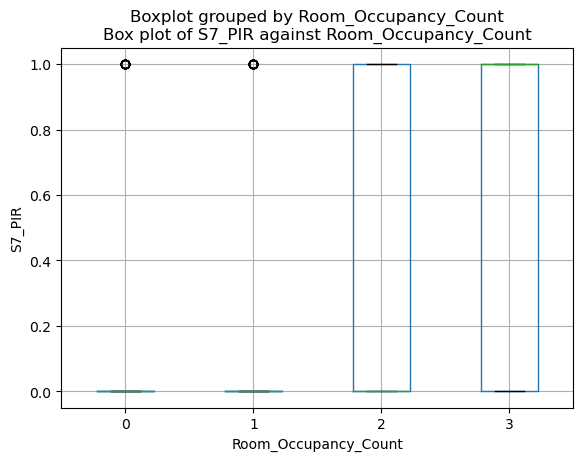

In [3]:

target_column = 'Room_Occupancy_Count'

feature_columns = df.columns.drop([target_column, 'Date', 'Time'])

for feature_column in feature_columns:
    df[feature_column] = pd.to_numeric(df[feature_column], errors='coerce')
    
    df.boxplot(column=feature_column, by=target_column)
    plt.xlabel(target_column)
    plt.ylabel(feature_column)
    plt.title(f'Box plot of {feature_column} against {target_column}')

    plt.show()


Except for CO2 and motion sensors, the mean reading of the sensors over all the 4 classes vary, hence we can say that the readings are useful in classifying the data

## EDA

### Shape of the dataset

In [4]:
print('The dataset contains ' + str(df.shape[0])+ ' rows' + ' and ' + str(df.shape[1])+ ' columns' )

The dataset contains 10129 rows and 19 columns


### Check for null values

In [5]:
df.isnull().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

There are no null values in any of the columns

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.940000,25.190000,25.38,25.63,26.380000
S2_Temp,10129.0,25.546059,0.586325,24.750000,25.190000,25.38,25.63,29.000000
S3_Temp,10129.0,25.056621,0.427283,24.440000,24.690000,24.94,25.38,26.190000
S4_Temp,10129.0,25.754125,0.356434,24.940000,25.440000,25.75,26.00,26.560000
S1_Light,10129.0,25.445059,51.011264,0.000000,0.000000,0.00,12.00,165.000000
S2_Light,10129.0,26.016290,67.304170,0.000000,0.000000,0.00,14.00,258.000000
S3_Light,10129.0,34.248494,58.400744,0.000000,0.000000,0.00,50.00,280.000000
S4_Light,10129.0,13.220259,19.602219,0.000000,0.000000,0.00,22.00,74.000000
S1_Sound,10129.0,0.168178,0.316709,0.060000,0.070000,0.08,0.08,3.880000
S2_Sound,10129.0,0.120066,0.266503,0.040000,0.050000,0.05,0.06,3.440000


## Check for duplicates

In [7]:
num_duplicates = df.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 0


## Cheking for unique values in targert variable

In [8]:
unique_values = df['Room_Occupancy_Count'].unique()
print("Unique values in 'Room_Occupancy_Count' column:")
print(unique_values)

Unique values in 'Room_Occupancy_Count' column:
[1 2 3 0]


Since the target variable has 4 uniques outputs, we can approach this as a classification problem

## Checking the class distribution of target variable

In [9]:
features = df.columns.to_list()[:-1]
target = 'Room_Occupancy_Count'

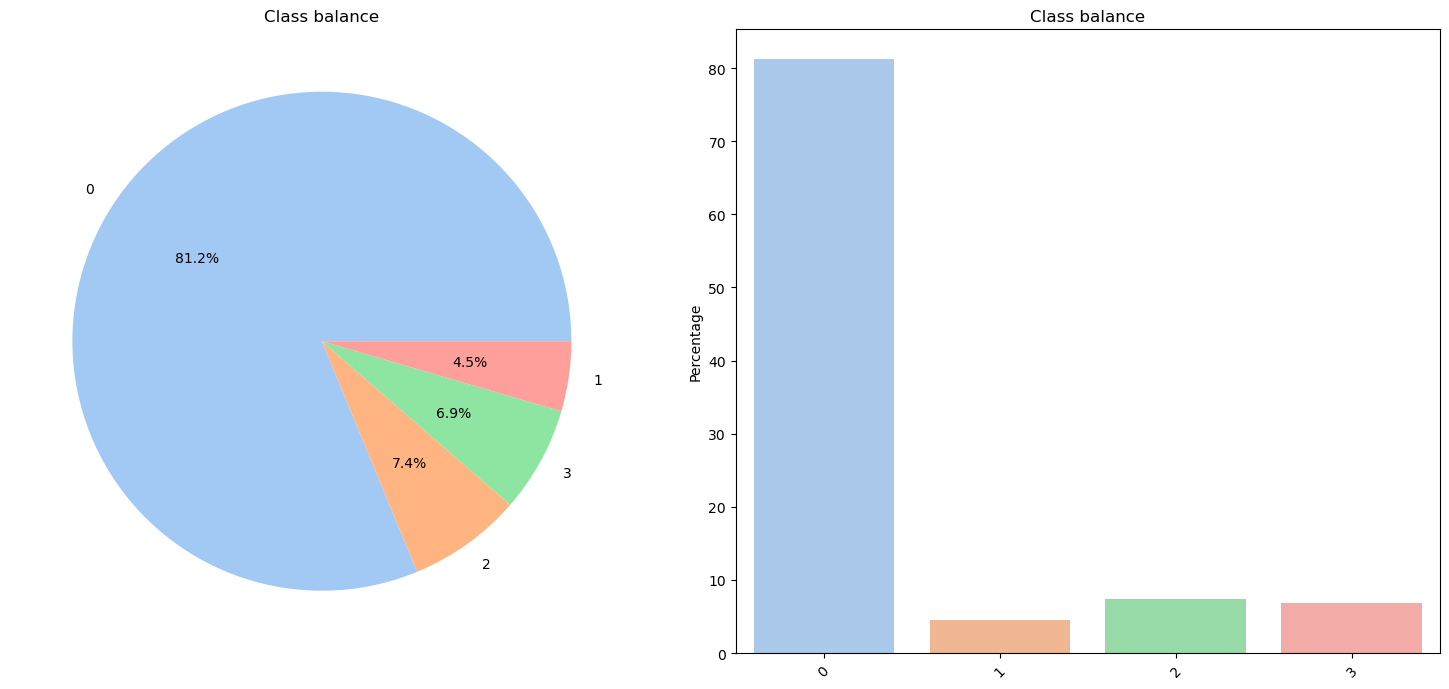

In [10]:

value_counts = df[target].value_counts(normalize=True) * 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
ax1.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))
ax1.set_title('Class balance')

sns.barplot(x=value_counts.index, y=value_counts, ax=ax2, palette='pastel')
ax2.set_title('Class balance')
ax2.set_ylabel('Percentage')

plt.setp(ax2.get_xticklabels(), rotation=45)

plt.tight_layout()

plt.show()


It is evident that around 81% of the data belongs to the target class 0, and the remaing classes have very less records compared to it. There is an imbalance in data, which might make out predictions more biased towards class 0. Hence we have to find possible ways to handle this imbalanced data

## Checking Outliers

For Light detecting sensors

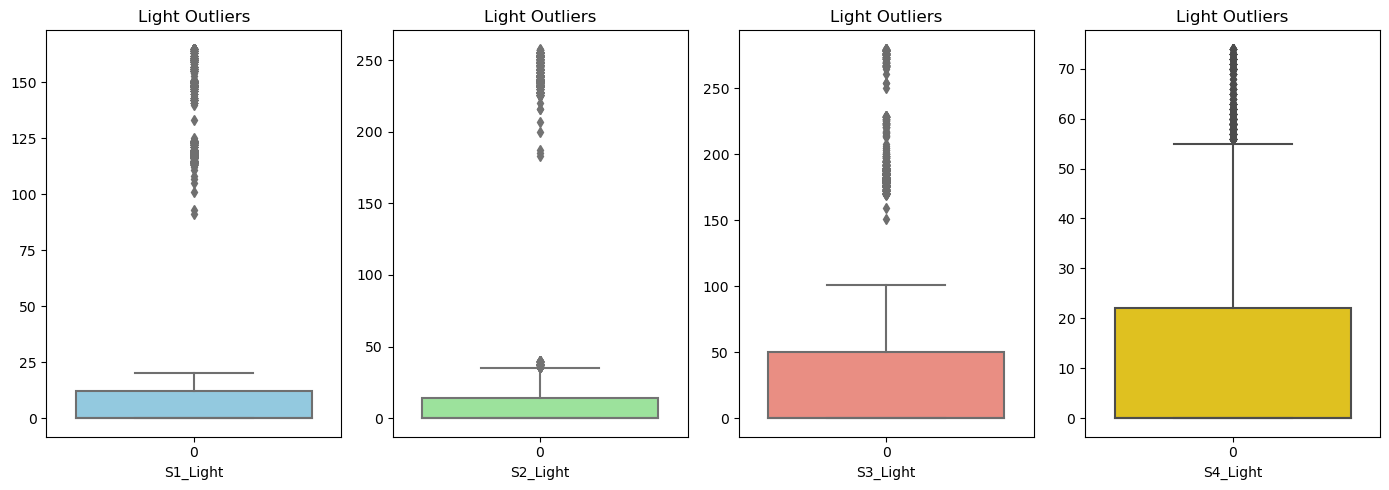

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

# Plot box plots for each 'S1_Light', 'S2_Light', 'S3_Light', and 'S4_Light' columns
for i, column in enumerate(['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']):
    sns.boxplot(data=df[column], ax=axes[i], color=colors[i])
    axes[i].set_xlabel(column)
    axes[i].set_title('Light Outliers')
    

plt.tight_layout()
plt.show()

It is evident from the graphs that most of these variables' densities are close to 0. This suggests that there isn't a light source at the moment, which makes sense given that class 0 records make up about 80% of all data.


For everyday activities, a room's illumination intensity typically ranges from 100 to 300 lux. Values above the 75th percentile are therefore considered noteworthy. Additionally, they don't go above the typical illumination levels.

For light sensor features, then, these represent normal data rather than outliers.


## For sound sensors

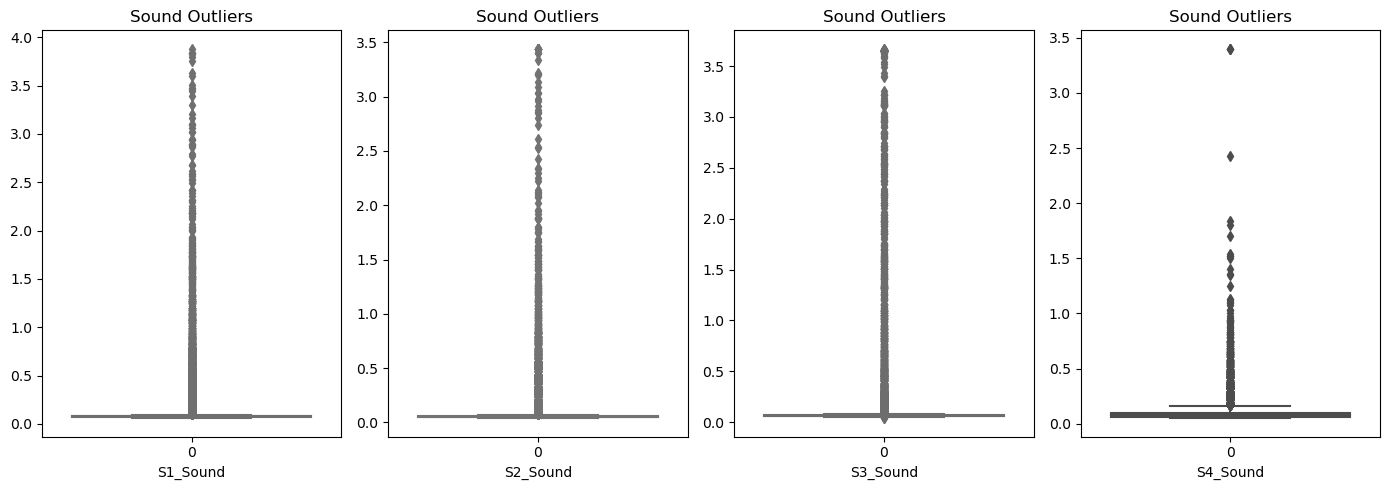

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

for i, column in enumerate(['S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound']):
    sns.boxplot(data=df[column], ax=axes[i], color=colors[i])
    axes[i].set_xlabel(column)
    axes[i].set_title('Sound Outliers')
    
plt.tight_layout()

plt.show()

For sound sensors, most of the valuse falls around 0, which is obvious that majority of the data belongs to class 0, which implies there are no people who make noise.
There are no outliers. The values of all four sound sensors range from 0 to 4 volts

## For Temperature sensor

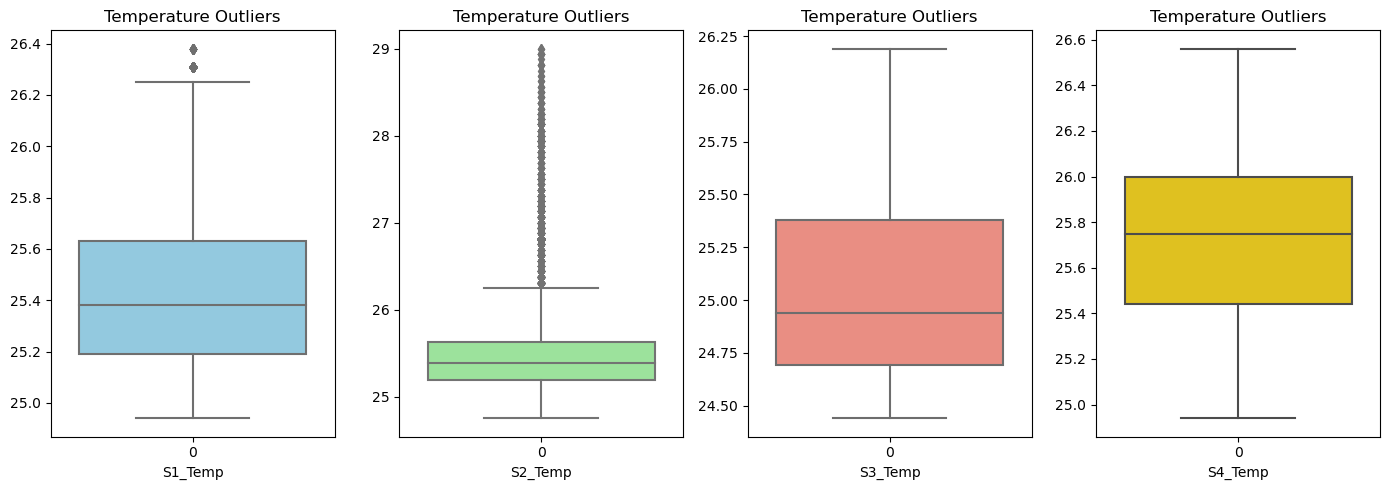

In [13]:

fig, axes = plt.subplots(1, 4, figsize=(14, 5))

colors = ['skyblue', 'lightgreen', 'salmon', 'gold']

# Plot box plots for each 'S1_Temp', 'S2_Temp', 'S3_Temp', and 'S4_Temp' columns
for i, column in enumerate(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp']):
    sns.boxplot(data=df[column], ax=axes[i], color=colors[i])
    axes[i].set_xlabel(column)
    axes[i].set_title('Temperature Outliers')


plt.tight_layout()
plt.show()

For C02 sensors

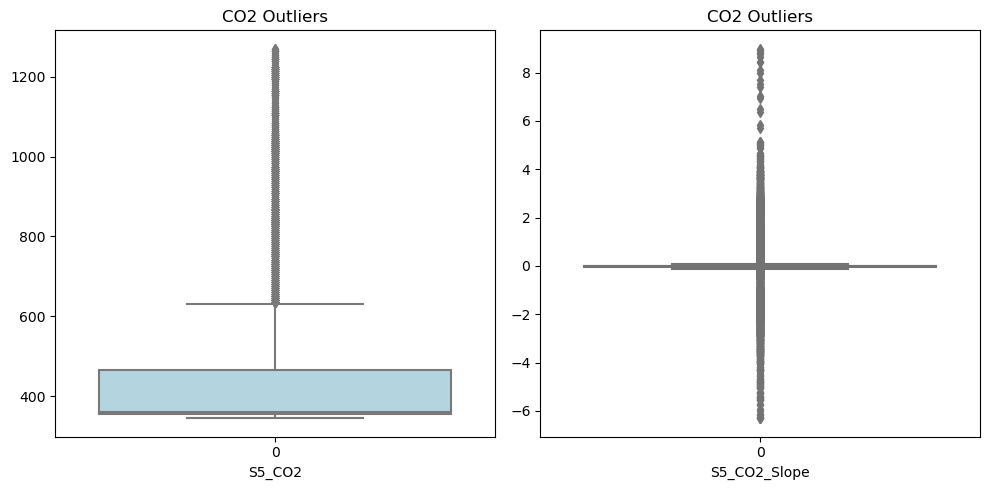

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

colors = ['lightblue', 'lightgreen']

for i, column in enumerate(['S5_CO2', 'S5_CO2_Slope']):
    sns.boxplot(data=df[column], ax=axes[i], color=colors[i])
    axes[i].set_xlabel(column)
    axes[i].set_title('CO2 Outliers')

plt.tight_layout()

plt.show()


variations in the CO2 content between two measurements taken back-to-back. The range is -7 (seven percent reduction) to 9 (nine percent increase). More people might theoretically lead to larger concentration changes. We don't see any anomalies.


Correlation Matrix:


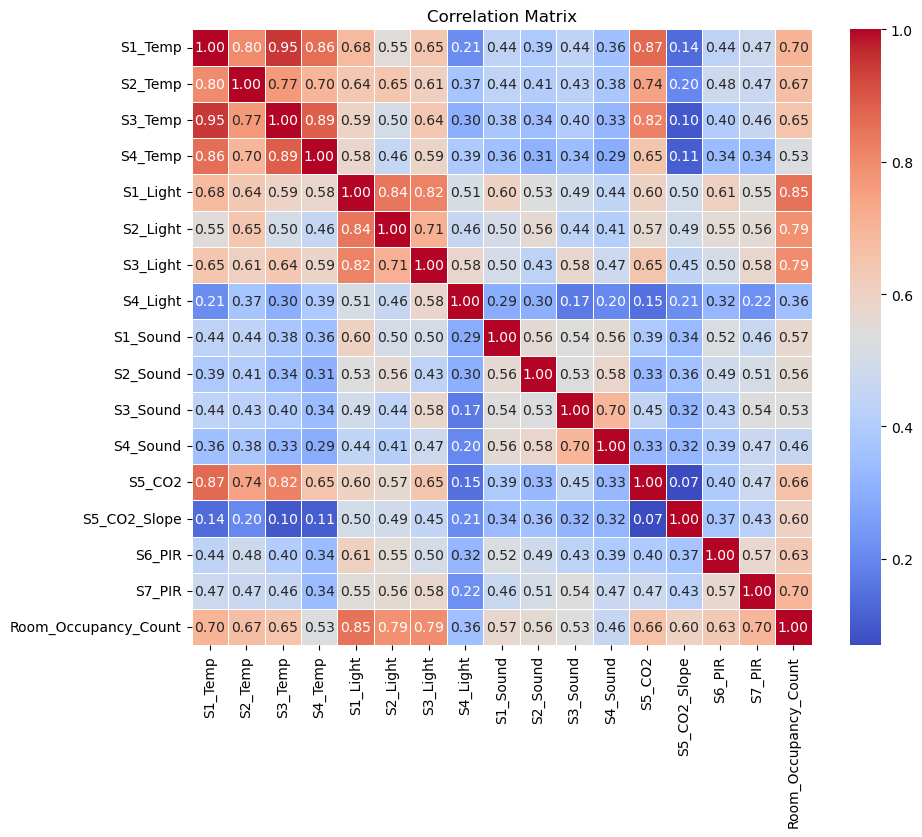

In [15]:
corr_matrix = df.corr()
print("Correlation Matrix:")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Temperature and Light: Moderate positive correlation (0.58 to 0.68), suggesting that when temperature increases, light intensity tends to increase as well, though not strongly.

Light and Sound: Moderate positive correlation (0.30 to 0.60), indicating that higher light intensity correlates with higher sound levels.

Sound and CO2 Level: Weak to moderate positive correlation (0.33 to 0.56), suggesting a potential relationship between sound levels and CO2 levels.

CO2 Level and Occupancy Count: Moderate positive correlation (0.66), indicating that higher CO2 levels may correlate with higher occupancy in the room.

CO2 Slope and Occupancy Count: Moderate positive correlation (0.60), suggesting that the rate of change of CO2 level over time may be related to the occupancy count.

From the correlations between the features and the target variable (Room_Occupancy_Count), we can draw the following inferences:

Temperature:

There is a moderate positive correlation between temperature readings (S1_Temp and S4_Temp) and room occupancy count.
Higher temperatures might indicate more occupants in the room, possibly due to increased comfort levels or higher activity.
Light:

There is a strong positive correlation between light intensity (S1_Light) and room occupancy count.
Higher light intensity could imply more people present in the room, possibly due to daytime or increased activity.
Sound:

There is a moderate positive correlation between sound levels (S1_Sound, S2_Sound, S3_Sound, and S4_Sound) and room occupancy count.
Higher sound levels might suggest more activity or conversation in the room, correlating with higher occupancy.
CO2 Level:

There is a moderate positive correlation between CO2 levels (S5_CO2) and room occupancy count.
Elevated CO2 levels may indicate more occupants exhaling carbon dioxide in the room, especially in crowded or poorly ventilated spaces.
CO2 Slope:

There is a moderate positive correlation between the slope of CO2 levels (S5_CO2_Slope) and room occupancy count.
A steeper increase in CO2 levels over time might suggest a rapid increase in occupancy or reduced ventilation in the room.

# Feature Selection

We are investigating the relationship between specific physical factors (temperature, illumination, sound, CO2 saturation, and motion detection) and the presence or absence, as well as the amount, of individuals in the space, hence the date and time elements must be removed. We are not interested in the dependence of people's presence on the day of the week and the time of day. In essence, time series analysis is a very distinct task.


In [16]:
df=df.drop(['Date','Time'],axis=1)

In [17]:
features_corr_matrix = df.drop(columns=['Room_Occupancy_Count']).corr()
threshold = 0.75

highly_correlated_dict = {}

for i in range(len(features_corr_matrix.columns)):
    for j in range(i):
        if abs(features_corr_matrix.iloc[i, j]) > threshold:
            col1, col2 = features_corr_matrix.columns[i], features_corr_matrix.columns[j]
           
            if col1 in highly_correlated_dict:
                highly_correlated_dict[col1].add(col2)
            else:
                highly_correlated_dict[col1] = {col2}
            if col2 in highly_correlated_dict:
                highly_correlated_dict[col2].add(col1)
            else:
                highly_correlated_dict[col2] = {col1}

# Print the sets of highly correlated features
for feature, correlated_features in highly_correlated_dict.items():
    print(f"Features highly correlated with '{feature}': {correlated_features}")


Features highly correlated with 'S2_Temp': {'S1_Temp', 'S3_Temp'}
Features highly correlated with 'S1_Temp': {'S4_Temp', 'S5_CO2', 'S2_Temp', 'S3_Temp'}
Features highly correlated with 'S3_Temp': {'S1_Temp', 'S4_Temp', 'S5_CO2', 'S2_Temp'}
Features highly correlated with 'S4_Temp': {'S1_Temp', 'S3_Temp'}
Features highly correlated with 'S2_Light': {'S1_Light'}
Features highly correlated with 'S1_Light': {'S3_Light', 'S2_Light'}
Features highly correlated with 'S3_Light': {'S1_Light'}
Features highly correlated with 'S5_CO2': {'S1_Temp', 'S3_Temp'}


The S2,S1 and S3 Temp featuers are higly correlated, similarly S1,S2, S3 light sesnsors shows high correlation, in order to improve the computational efficiency, I'm approaching to remove the S2 and S3 featues in both light and temperature sensors, and use only S1 for prediction

Analysing the two features with binary values

In [18]:
pd.DataFrame(df.groupby('S6_PIR')[target].value_counts())

Room_Occupancy_Count
S6_PIR Room_Occupancy_Count                      
0      0                                     8208
       2                                      390
       3                                      317
       1                                      301
1      3                                      377
       2                                      358
       1                                      158
       0                                       20

In [19]:
pd.DataFrame(df.groupby('S7_PIR')[target].value_counts())

Room_Occupancy_Count
S7_PIR Room_Occupancy_Count                      
0      0                                     8216
       1                                      440
       2                                      428
       3                                      239
1      3                                      455
       2                                      320
       1                                       19
       0                                       12

For class 0, the motion sensors function well enough (with only 20 and 12 mistakes, respectively). For classes 1, 2, and 3, though, things aren't going as planned. The feature values for these sensors are 0 (they should be 1) in about half of the scenarios where people are present in the space. Furthermore, in roughly a thousand instances in which no one is present in the room, the feature values are 1 (they ought to be 0). Furthermore, in 96% of records for class 1, sensor S7_PIR has a value of 0, which defies the criterion (this feature should have a value of 1 when people are present).

This could be the result of inaccurate operation, calibration, digitization, or manual labeling of the target variable (manually labeled actual data, such as the number of persons in the room).

It should be mentioned that these two qualities are primarily for a different purpose. The binary nature of the characteristics means that they are intended for a binary classification problem, namely, identifying whether or not individuals are present in the room. In this instance, there is no task at all if the data gathered by the sensors is accurate. The feature value is 1 if a sensor detects motion at a specific moment, and 0 otherwise. Additionally, assuming the sensors function properly, the data they provide provides a yes-or-no response (1 or 0). No solution (at least not a deterministic one) can be provided if they operate improperly or give contradicting information for a brief period of time.

Hence, it would be idle to remove these features



To make our decision more clear, we can try calculating the mutial index values of each featute with respect to the target

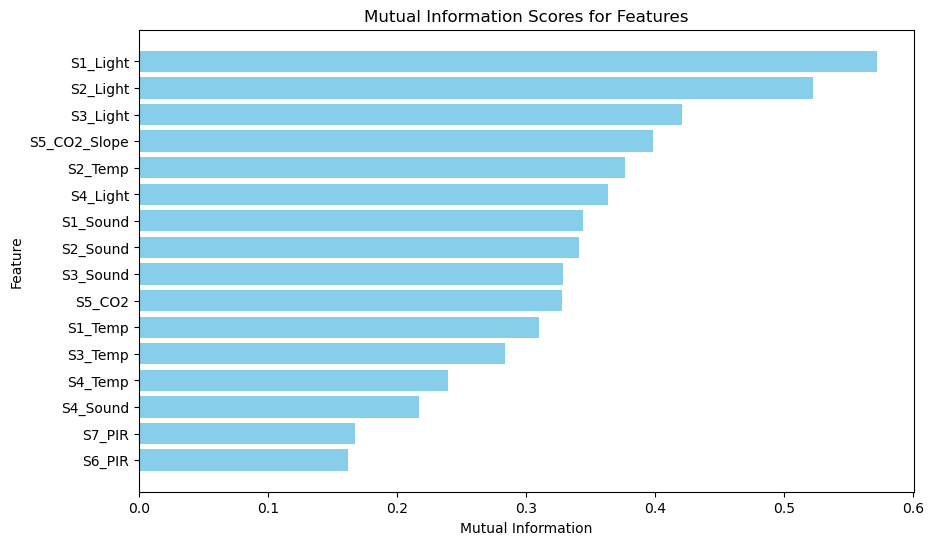

In [20]:
X = df.drop(columns=['Room_Occupancy_Count'])
y = df['Room_Occupancy_Count']

mi_scores = mutual_info_classif(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Information': mi_scores})
mi_df.sort_values(by='Mutual_Information', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
plt.barh(mi_df['Feature'], mi_df['Mutual_Information'], color='skyblue')
plt.xlabel('Mutual Information')
plt.ylabel('Feature')
plt.title('Mutual Information Scores for Features')
plt.gca().invert_yaxis()
plt.show()


From Mutial information values, we can obserrve that S7_PIR and S6_PIR has the least score.
Taking our analyis into account, we can drop these two features

In [21]:
df=df.drop(['S7_PIR','S6_PIR','S2_Temp','S3_Temp','S2_Light','S3_Light'], axis=1)

In [22]:
df.head(5)

,S1_Temp,S4_Temp,S1_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,Room_Occupancy_Count
0,24.94,25.38,121,40,0.08,0.19,0.06,0.06,390,0.769231,1
1,24.94,25.44,121,40,0.93,0.05,0.06,0.06,390,0.646154,1
2,25.00,25.44,121,40,0.43,0.11,0.08,0.06,390,0.519231,1
3,25.00,25.44,121,40,0.41,0.10,0.10,0.09,390,0.388462,1
4,25.00,25.44,121,40,0.18,0.06,0.06,0.06,390,0.253846,1


In [23]:
df.shape

(10129, 11)

In [24]:
X = df.drop(columns=['Room_Occupancy_Count'])
y = df['Room_Occupancy_Count']

## Synthetic Minority Over-sampling Technique(SMOTE) to handle imbalanced class distribution

In [25]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled_df = pd.DataFrame(y_resampled, columns=['Room_Occupancy_Count'])

resampled_df = pd.concat([X_resampled_df, y_resampled_df], axis=1)

print("Class distribution after SMOTE:\n", resampled_df['Room_Occupancy_Count'].value_counts())

Class distribution after SMOTE:
 1    8228
2    8228
3    8228
0    8228
Name: Room_Occupancy_Count, dtype: int64


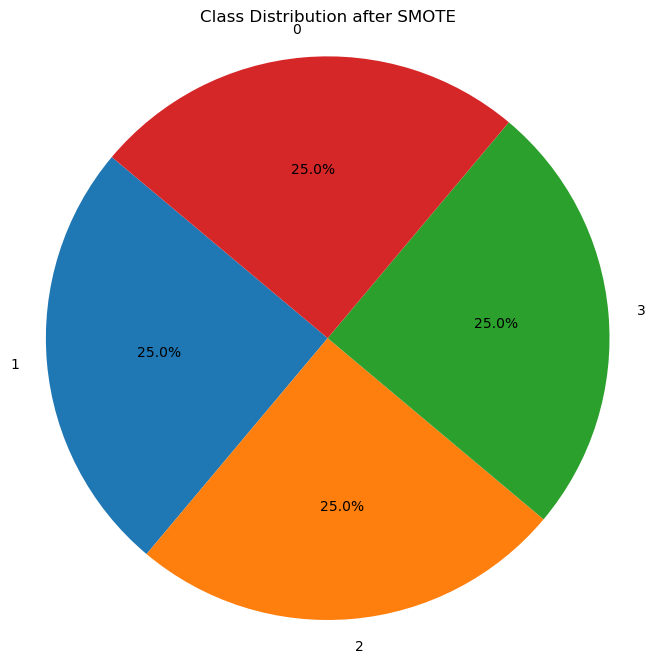

In [26]:

class_distribution = resampled_df['Room_Occupancy_Count'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(class_distribution, labels=class_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution after SMOTE')
plt.axis('equal')
plt.show()


## Base Model Evaluation

In [50]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

models = {
    'LogisticRegression': LogisticRegression(),
    'KNN': KNeighborsClassifier(n_neighbors=100),
    'NeuralNetwork': MLPClassifier(),
    'DecisionTree': DecisionTreeClassifier(max_depth=3)
}

model_names = []
F1_score = []
Precision = []
Recall = []
Accuracy = []

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

for model_name, model in models.items():
    cvs = cross_validate(model, X_resampled, y_resampled, cv=cv, scoring=['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy'])
    model_names.append(model_name)
    F1_score.append(cvs['test_f1_weighted'].mean())
    Recall.append(cvs['test_recall_weighted'].mean())
    Precision.append(cvs['test_precision_weighted'].mean())
    Accuracy.append(cvs['test_accuracy'].mean())

results = pd.DataFrame({'Model': model_names,
                        'F1-score': F1_score,
                        'Recall': Recall,
                        'Precision': Precision,
                        'Accuracy': Accuracy})

print(tabulate(results, headers='keys', tablefmt='pretty'))


+---+--------------------+--------------------+--------------------+--------------------+--------------------+
|   |       Model        |      F1-score      |       Recall       |     Precision      |      Accuracy      |
+---+--------------------+--------------------+--------------------+--------------------+--------------------+
| 0 | LogisticRegression | 0.6760077085606303 | 0.680785031978869  | 0.6736622679632779 | 0.680785031978869  |
| 1 |        KNN         | 0.9700121619071446 | 0.9699197805014025 | 0.971259098537482  | 0.9699197805014025 |
| 2 |   NeuralNetwork    | 0.9787453047635121 | 0.9787617785526169 | 0.9793693516994706 | 0.9787617785526169 |
| 3 |    DecisionTree    | 0.8907349287600916 | 0.8928065845590932 | 0.8996429610369227 | 0.8928065845590932 |
+---+--------------------+--------------------+--------------------+--------------------+--------------------+


In [53]:

params = {
    'max_depth': [3, 5, 7, 9],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

scv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

print("Tuning hyperparameters for Decision Tree")
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1_weighted', cv=scv)
grid_search.fit(X_resampled, y_resampled)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

best_model.fit(X_resampled, y_resampled)



Tuning hyperparameters for Decision Tree
Best hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 5}


DecisionTreeClassifier(max_depth=9, min_samples_split=5)

In [56]:
best_params = grid_search.best_params_
best_decision_tree = DecisionTreeClassifier(criterion=best_params['criterion'],
                                            max_depth=best_params['max_depth'],
                                            min_samples_split=best_params['min_samples_split'],
                                            min_samples_leaf=best_params['min_samples_leaf'])
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)
cvs = cross_validate(best_decision_tree, X_scaled, y_resampled, cv=cv, scoring=['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy'])
F1_score = cvs['test_f1_weighted'].mean()
Recall = cvs['test_recall_weighted'].mean()
Precision = cvs['test_precision_weighted'].mean()
Accuracy = cvs['test_accuracy'].mean()
results4 = pd.DataFrame({'Model': ['DecisionTree'],
                        'F1-score': [F1_score],
                        'Recall': [Recall],
                        'Precision': [Precision],
                        'Accuracy': [Accuracy]})
print(results4)


          Model  F1-score    Recall  Precision  Accuracy
0  DecisionTree  0.995898  0.995898   0.995905  0.995898


In [57]:

model = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

scv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

print("Tuning hyperparameters for KNN")
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1_weighted', cv=scv)
grid_search.fit(X_resampled, y_resampled)
print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_
best_model.fit(X_resampled, y_resampled)


Tuning hyperparameters for KNN
Best hyperparameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

In [58]:

best_params = grid_search.best_params_
knn = KNeighborsClassifier(n_neighbors=best_params['n_neighbors'], weights=best_params['weights'], p=best_params['p'])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

cvs = cross_validate(knn, X_scaled, y_resampled, cv=cv, scoring=['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy'])
F1_score = cvs['test_f1_weighted'].mean()
Recall = cvs['test_recall_weighted'].mean()
Precision = cvs['test_precision_weighted'].mean()
Accuracy = cvs['test_accuracy'].mean()

results1 = pd.DataFrame({'Model': ['KNN'],
                        'F1-score': [F1_score],
                        'Recall': [Recall],
                        'Precision': [Precision],
                        'Accuracy': [Accuracy]})

print(results1)


  Model  F1-score    Recall  Precision  Accuracy
0   KNN  0.998511  0.998511   0.998512  0.998511


In [59]:
model = LogisticRegression(random_state=100)
params = {
    'C': np.logspace(-3, 3, 7),
    'penalty': ['l1', 'l2']
}

scv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

print("Tuning hyperparameters for Logistic Regression")
grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1_weighted', cv=scv)
grid_search.fit(X_resampled, y_resampled)

print("Best hyperparameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

best_model.fit(X_resampled, y_resampled)



Tuning hyperparameters for Logistic Regression
Best hyperparameters: {'C': 10.0, 'penalty': 'l2'}


LogisticRegression(C=10.0, random_state=100)

In [60]:
best_hyperparameters = {'C': 10.0, 'penalty': 'l2'}

logistic_model_tuned = LogisticRegression(**best_hyperparameters)

# Initialize result lists
model_names = []
F1_score = []
Precision = []
Recall = []
Accuracy = []

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

cvs = cross_validate(logistic_model_tuned, X_scaled, y_resampled, cv=cv, scoring=['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy'])

model_names.append('LogisticRegression_Tuned')
F1_score.append(cvs['test_f1_weighted'].mean())
Recall.append(cvs['test_recall_weighted'].mean())
Precision.append(cvs['test_precision_weighted'].mean())
Accuracy.append(cvs['test_accuracy'].mean())

results2 = pd.DataFrame({'Model': model_names,
                        'F1-score': F1_score,
                        'Recall': Recall,
                        'Precision': Precision,
                        'Accuracy': Accuracy})

# Print results
print(results2)


                      Model  F1-score    Recall  Precision  Accuracy
0  LogisticRegression_Tuned  0.893083  0.893443   0.892863  0.893443


In [62]:

model = MLPClassifier(random_state=100)
param_dist = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['logistic', 'relu'],
    'alpha': [0.0001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}


scv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

print("Tuning hyperparameters for MLP Classifier")
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=4, scoring='f1_weighted', cv=scv, random_state=100)
random_search.fit(X_resampled, y_resampled)

print("Best hyperparameters:", random_search.best_params_)

best_model = random_search.best_estimator_

best_model.fit(X_resampled, y_resampled)


Tuning hyperparameters for MLP Classifier
Best hyperparameters: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'logistic'}


MLPClassifier(activation='logistic', hidden_layer_sizes=(50,),
              learning_rate='adaptive', random_state=100)

In [64]:
best_params = {'learning_rate': 'adaptive', 'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'activation': 'logistic'}
mlp_classifier = MLPClassifier(random_state=100, **best_params)

# Initialize result lists
model_names = ['MLPClassifier']
F1_score = []
Precision = []
Recall = []
Accuracy = []


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

cvs = cross_validate(mlp_classifier, X_scaled, y_resampled, cv=cv, scoring=['f1_weighted', 'recall_weighted', 'precision_weighted', 'accuracy'])
F1_score.append(cvs['test_f1_weighted'].mean())
Recall.append(cvs['test_recall_weighted'].mean())
Precision.append(cvs['test_precision_weighted'].mean())
Accuracy.append(cvs['test_accuracy'].mean())

results3 = pd.DataFrame({'Model': model_names,
                        'F1-score': F1_score,
                        'Recall': Recall,
                        'Precision': Precision,
                        'Accuracy': Accuracy})

print(results3)


           Model  F1-score    Recall  Precision  Accuracy
0  MLPClassifier  0.996538  0.996536   0.996543  0.996536


## Results After Hyperparameter Tuning

In [65]:

combined_df = pd.concat([results1, results2, results3, results4])
combined_df.reset_index(drop=True, inplace=True)
print(combined_df)

                      Model  F1-score    Recall  Precision  Accuracy
0                       KNN  0.998511  0.998511   0.998512  0.998511
1  LogisticRegression_Tuned  0.893083  0.893443   0.892863  0.893443
2             MLPClassifier  0.996538  0.996536   0.996543  0.996536
3              DecisionTree  0.995898  0.995898   0.995905  0.995898
